In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [271]:
### Read in values from text file
file_path = r"Cc_Ck_Input.txt"  # Replace with the actual path to your file

values = {}
with open(file_path, "r") as file:
    line = file.readline().strip()
    while line:
        if line.startswith("$$"):
            key = line[2:].strip()
            value = float(file.readline().strip())
            values[key] = value
        line = file.readline().strip()


ValueError: could not convert string to float: '$$ PRECONSOLIDATION_STRESS'

### Store Input Variables

In [269]:
### Cc Inputs
Pre_ConsolStress = values["PRECONSOLIDATION_STRESS"]
Cc = values["Cc"] # Virgin compression slope
Cr_ratio = values["Cr/Cc"] # Ratio of C_r to C_c
e0 = values["e0"] # Initial void ratio
ef = values["ef"] # Final value of void ratio
input_num_points = int(values["Input_Num_Points"]) # Number of spaces avalialable for inputs in PSDDF

### Ck Inputs
Cv = values["Cv (cm^2/s)"] * 1e-4
gamma_w = values["Gamma_w (kN/m^3)"]


1.0000000000000001e-07


In [248]:
num_points = input_num_points + 1 # Add a data point so that when the Cr and Cc arrays are later appened the length is correct

### Calculations

In [249]:
# Calculate the maximum eff_stres possible before e becomes negative
max_stress = 10**((e0-ef)/Cc + np.log10(Pre_ConsolStress) * (-Cr_ratio + 1))
print(max_stress)
# Percentage of the loading that is reloading (swell)
# (Used to calculate the number of points that should be used for the recompression)
Perc_reloading = (Pre_ConsolStress-1)/max_stress
print(Perc_reloading*100)

599.4842503189409
0.0


In [250]:
# Number of points to generate
# num_points = 100 + 1

### Rework this!!! This will likely cause a bug 
# Number of recompression points
num_Cr_points = 0#int(num_points * Perc_reloading + 1)
if num_Cr_points < 4 and Pre_ConsolStress > 1:
    num_Cr_points = 10
print("Number of Cr points: {:.2f}".format(num_Cr_points))

# Number of virgin compression points
num_Cc_points = num_points-num_Cr_points
print("Number of Cc points: {:.2f}".format(num_Cc_points))

Number of Cr points: 0.00
Number of Cc points: 69.00


In [251]:
### Define arrays of effective stress points

#### Virgin Compression initialization
Cc_eff_stress = np.linspace(Pre_ConsolStress, max_stress, num_Cc_points)

#### Recompression initializations 
Cr_eff_stress = np.linspace(1, Pre_ConsolStress,num_Cr_points)


In [252]:
### Void ratio points for recompression
e_recomp = -1 * Cr_ratio * Cc * np.log10(Cr_eff_stress) + e0

### Void ratio for virgin compression

# Calculate intercept for Virgin compression line
if len(e_recomp) == 0:
    b = e0 + Cc * np.log10(Pre_ConsolStress)
else:
    b = e_recomp[-1] + Cc * np.log10(Pre_ConsolStress)

# Calulcate void ratios for virgin compression line
e_virgin = -Cc * np.log10(Cc_eff_stress) + b

### Append the two arrays
eff_stress = np.append(Cr_eff_stress, Cc_eff_stress[num_Cr_points:])
es = np.append(e_recomp, e_virgin[num_Cr_points:])

### Plot

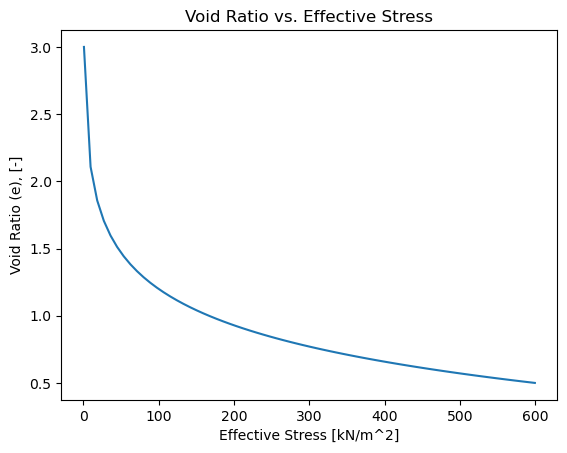

In [253]:
plt.title("Void Ratio vs. Effective Stress")
plt.xlabel("Effective Stress [kN/m^2]")
plt.ylabel("Void Ratio (e), [-]")
plt.plot(eff_stress, es)

plt.show()

### Permeability Information

Permeability, $k_{v}$, is defined as 
\begin{equation}
    k_{v} = \gamma_w m_{v} c_{v}
\end{equation}
where, <br>
$\gamma_w$: Specific weight of water <br>
$m_{v}$: Coefficient of compressibility <br>
$c_{v}$: consolidation coefficient <br>

Assuming that $\gamma_w$ and $c_v$ are known then the only unknown is $m_v$. <br>
$m_{v}$ is defined as:
\begin{equation}
    m_{v} = \frac{\Delta \varepsilon_{V}}{\Delta \sigma}
\end{equation}
where $\Delta \varepsilon$ represents a change in volumetric strain and $\Delta \sigma$ represents the corresponding change in stress.

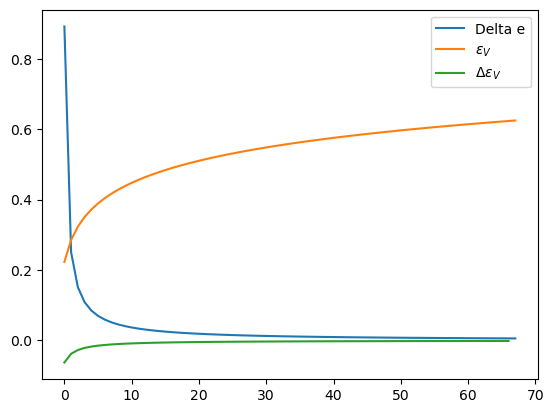

[-0.06261521 -0.0378537  -0.02721567 -0.02126346 -0.01745325 -0.01480325
 -0.0128529  -0.01135716 -0.01017354 -0.0092135  -0.00841914 -0.00775095
 -0.00718106 -0.00668927 -0.00626054 -0.00588347 -0.00554926 -0.00525098
 -0.00498314 -0.0047413  -0.00452186 -0.00432183 -0.00413875 -0.00397055
 -0.0038155  -0.0036721  -0.00353908 -0.00341537 -0.00330002 -0.0031922
 -0.00309121 -0.00299641 -0.00290726 -0.00282325 -0.00274397 -0.00266902
 -0.00259805 -0.00253076 -0.00246686 -0.00240612 -0.00234829 -0.00229318
 -0.0022406  -0.00219037 -0.00214235 -0.00209638 -0.00205235 -0.00201013
 -0.00196961 -0.00193069 -0.00189329 -0.0018573  -0.00182265 -0.00178928
 -0.0017571  -0.00172607 -0.0016961  -0.00166717 -0.0016392  -0.00161215
 -0.00158599 -0.00156066 -0.00153612 -0.00151235 -0.0014893  -0.00146694
 -0.00144524]


In [254]:
# Calc changes in void ratio
delta_es = es[num_Cr_points:-1] - es[num_Cr_points+1:]
plt.plot(delta_es, label = "Delta e")

# # Calc volumetric strain
epsilon_V = np.cumsum(delta_es)/(1+e0)
plt.plot(epsilon_V, label = "$\epsilon_{V}$")


# # Calc delta volumetric strain
delta_epsilon_V = epsilon_V[:-1] - epsilon_V[1:]

plt.plot(delta_epsilon_V, label = "$\Delta \epsilon_{V}$")
plt.legend()
plt.show()
print(delta_epsilon_V)

In [255]:
delta_epsilonV_2 = (es)/1+e0
print(delta_epsilonV_2)

[6.         5.10784712 4.85738628 4.70597147 4.59710878 4.51205493
 4.44224195 4.38302895 4.33161735 4.28618873 4.24549459 4.20864057
 4.174964   4.14396022 4.11523598 4.08847891 4.06343675 4.03990286
 4.01770583 3.99670191 3.97676934 3.95780413 3.9397167  3.92242939
 3.90587439 3.88999218 3.87473019 3.86004181 3.84588547 3.83222397
 3.81902389 3.80625507 3.79389023 3.78190457 3.77027554 3.75898252
 3.74800664 3.73733058 3.72693838 3.71681535 3.70694789 3.69732342
 3.68793025 3.67875752 3.66979514 3.66103366 3.65246427 3.64407874
 3.63586933 3.62782881 3.61995037 3.61222759 3.60465445 3.59722525
 3.58993464 3.58277752 3.57574911 3.56884485 3.56206043 3.55539177
 3.54883497 3.54238636 3.53604241 3.52979978 3.5236553  3.51760591
 3.51164872 3.50578097 3.5       ]


In [256]:
# Calc delta stress
delta_eff_stress = eff_stress[num_Cr_points:-1] - eff_stress[num_Cr_points+1:]

# Calc m_v
m_v = delta_epsilon_V/delta_eff_stress[1:] #[-/kN]

# Calc permeability
k = gamma_w * m_v * Cv * 100 #[cm/s]

#least-Squares fit of data
coefficients = np.polyfit(np.log10(k), es[num_Cr_points + 2:], deg = 1)

# Generate the best-fit line
best_fit_line = np.polyval(coefficients, np.log10(k))

# Print Best fit coefficients
print("## LS- Best fit coefficients ##")
print("Slope: {:.4f}\nIntercept: {:.4f}".format(coefficients[0], coefficients[1]))


## LS- Best fit coefficients ##
Slope: 0.8582
Intercept: 7.1958


[1.28470514e-05 1.17525610e-06 6.00535312e-07 4.00181422e-07
 2.98892992e-07 2.37954275e-07 1.97340014e-07 1.68375005e-07
 1.46697499e-07 1.29877329e-07 1.16454431e-07 1.05499274e-07
 9.63922718e-08 8.87047117e-08 8.21306142e-08 7.64458112e-08
 7.14823578e-08 6.71119742e-08 6.32350068e-08 5.97728791e-08
 5.66628078e-08 5.38540320e-08 5.13050722e-08 4.89817050e-08
 4.68554459e-08 4.49023972e-08 4.31023620e-08 4.14381557e-08
 3.98950659e-08 3.84604241e-08 3.71232629e-08 3.58740411e-08
 3.47044189e-08 3.36070752e-08 3.25755572e-08 3.16041552e-08
 3.06877991e-08 2.98219715e-08 2.90026345e-08 2.82261675e-08
 2.74893154e-08 2.67891432e-08 2.61229979e-08 2.54884753e-08
 2.48833919e-08 2.43057598e-08 2.37537657e-08 2.32257518e-08
 2.27202000e-08 2.22357169e-08 2.17710219e-08 2.13249355e-08
 2.08963700e-08 2.04843204e-08 2.00878569e-08 1.97061181e-08
 1.93383044e-08 1.89836730e-08 1.86415330e-08 1.83112405e-08
 1.79921952e-08 1.76838362e-08 1.73856395e-08 1.70971145e-08
 1.68178016e-08 1.654726

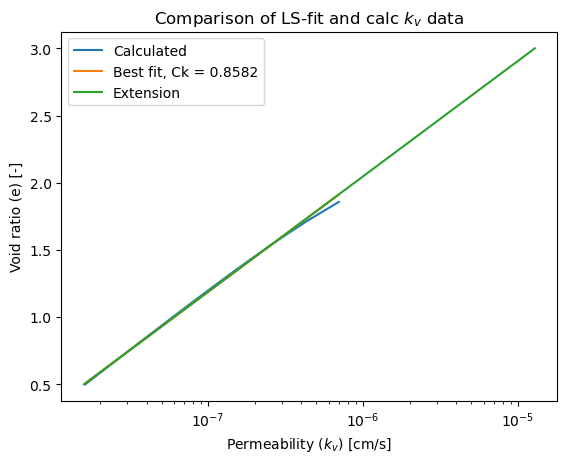

In [257]:
# Plot calculated permeability
plt.semilogx(k, es[num_Cr_points + 2:], label = "Calculated")

#Plot fitted permeability
plt.semilogx(k, best_fit_line, label = "Best fit, Ck = {:.4f}".format(coefficients[0]))
# print(k)

# Extrapolate values for kv at initial void ratios

#least-Squares fit of data
e_coefficients = np.polyfit(es[num_Cr_points + 2:], np.log10(k), deg = 1)

# Generate the best-fit line
k_best_fit_line = 10**np.polyval(e_coefficients, es)
print(k_best_fit_line)
plt.semilogx(k_best_fit_line, es, label = "Extension")

#Plot properties
plt.title("Comparison of LS-fit and calc $k_{v}$ data")
plt.xlabel("Permeability ($k_{v}$) [cm/s]")
plt.ylabel("Void ratio (e) [-]")
plt.legend()
plt.show()

In [258]:
print(es)

[3.         2.10784712 1.85738628 1.70597147 1.59710878 1.51205493
 1.44224195 1.38302895 1.33161735 1.28618873 1.24549459 1.20864057
 1.174964   1.14396022 1.11523598 1.08847891 1.06343675 1.03990286
 1.01770583 0.99670191 0.97676934 0.95780413 0.9397167  0.92242939
 0.90587439 0.88999218 0.87473019 0.86004181 0.84588547 0.83222397
 0.81902389 0.80625507 0.79389023 0.78190457 0.77027554 0.75898252
 0.74800664 0.73733058 0.72693838 0.71681535 0.70694789 0.69732342
 0.68793025 0.67875752 0.66979514 0.66103366 0.65246427 0.64407874
 0.63586933 0.62782881 0.61995037 0.61222759 0.60465445 0.59722525
 0.58993464 0.58277752 0.57574911 0.56884485 0.56206043 0.55539177
 0.54883497 0.54238636 0.53604241 0.52979978 0.5236553  0.51760591
 0.51164872 0.50578097 0.5       ]


In [265]:
### Generate Columns for PSDDF

### Need three columns void ratio | effective stress | permeability
# Before appending the columns together need to add data points to pearmeability data
file_path = "output.csv"
with open(file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["e", "sigma", "k"])  # Write the header row
    writer.writerows(zip(["{:.3f}".format(value) for value in es],\
                         ["{:.2e}".format(value) for value in eff_stress],\
                         ["{:.2e}".format(value) for value in k_best_fit_line]))  # Write the data rows

In [262]:
help(pd.DataFrame.to_csv, )

Help on function to_csv in module pandas.core.generic:

to_csv(self, path_or_buf: 'FilePath | WriteBuffer[bytes] | WriteBuffer[str] | None' = None, sep: 'str' = ',', na_rep: 'str' = '', float_format: 'str | Callable | None' = None, columns: 'Sequence[Hashable] | None' = None, header: 'bool_t | list[str]' = True, index: 'bool_t' = True, index_label: 'IndexLabel | None' = None, mode: 'str' = 'w', encoding: 'str | None' = None, compression: 'CompressionOptions' = 'infer', quoting: 'int | None' = None, quotechar: 'str' = '"', lineterminator: 'str | None' = None, chunksize: 'int | None' = None, date_format: 'str | None' = None, doublequote: 'bool_t' = True, escapechar: 'str | None' = None, decimal: 'str' = '.', errors: 'str' = 'strict', storage_options: 'StorageOptions' = None) -> 'str | None'
    Write object to a comma-separated values (csv) file.
    
    Parameters
    ----------
    path_or_buf : str, path object, file-like object, or None, default None
        String, path object (imp